# Data Cleaning

### 0. Import necessary libraries

In [1]:
import gc
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm import tqdm_notebook


DATA_FOLDER = '../data/'
d_parser = lambda x: pd.datetime.strptime(x,'%d.%m.%Y')

warnings.filterwarnings("ignore")
import utils

### 1. Read the data

In [2]:
%%time

df_sales           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'), parse_dates =["date"],date_parser=d_parser)
df_items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
df_item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
df_shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

Wall time: 1min 44s


### 2. Check for outliers
Since, the outliers, can be found in item_cnt_day, that is the total quantity sold, and item_price, so will check both

In [3]:
df_sales.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


Outliers for item_cnt_day :  [1000.  624.  637.  669. 2169.]
Wall time: 305 ms


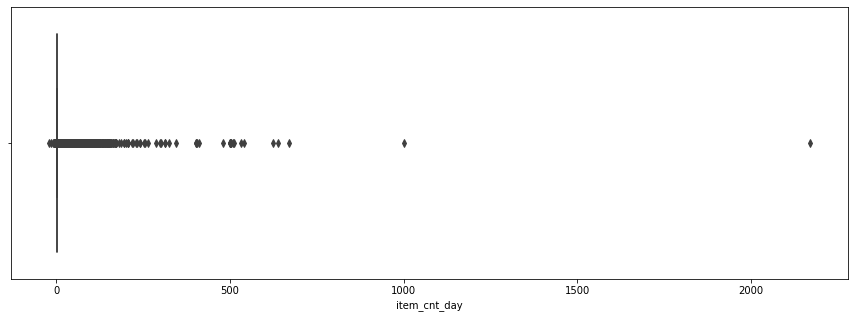

In [4]:
%%time
# for item quantity
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_cnt_day'])
print('Outliers for item_cnt_day : ', df_sales[df_sales['item_cnt_day']>600]['item_cnt_day'].unique())

In [5]:
%%time
# deleting the quantities which are greater than 600
df_sales = df_sales[df_sales['item_cnt_day']<=600]

Wall time: 288 ms


# Note: To be Tested Later

In [6]:
#df_sales = df_sales[df_sales['item_cnt_day'] <= 1001]
#df_sales = df_sales[df_sales['item_price'] <= 100000]

#item price, should obviously not be less than 0 ... either it should be deleted or imputed.
df_sales = df_sales[df_sales['item_price'] > 0]

Outliers for item_price :  [ 59200. 307980.]
Wall time: 288 ms


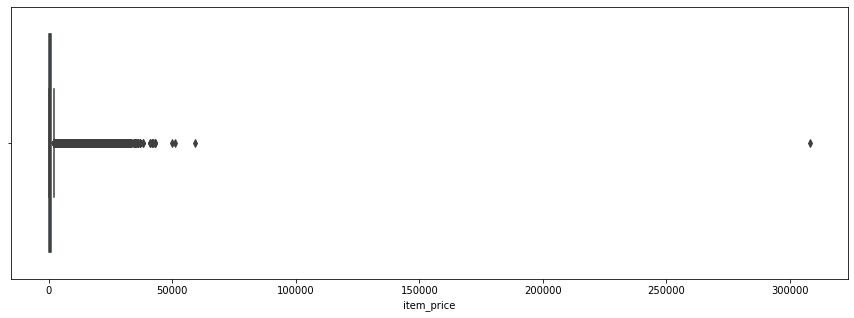

In [7]:
%%time
# checking for price
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_price'])
print('Outliers for item_price : ', df_sales[df_sales['item_price']>55000]['item_price'].unique())

In [8]:
%%time
# values more than 55k could be outliers, so deleting all above 55k
df_sales = df_sales[df_sales['item_price']<= 55000]

Wall time: 298 ms


### 3. Re-Checking after deletion of Outliers

Wall time: 297 ms


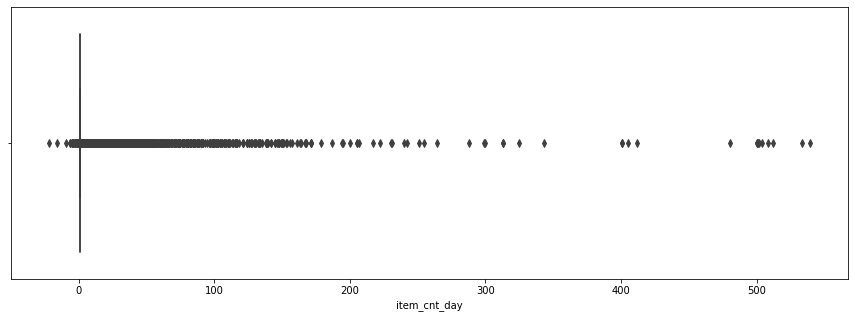

In [9]:
%%time
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_cnt_day'])

Wall time: 272 ms


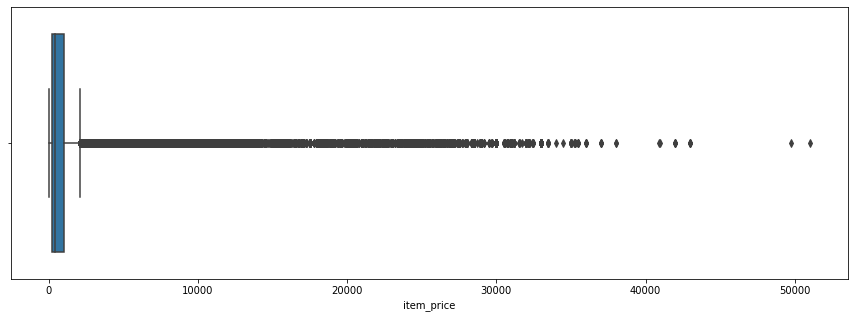

In [10]:
%%time
plt.figure(figsize=(15,5))
sns.boxplot(x=df_sales['item_price'])

In [11]:
#instantiate the object (all important functions are gathered in this class)
sales_util = utils.SalesUtils('')

### 4. Checking for possible duplications in Shops

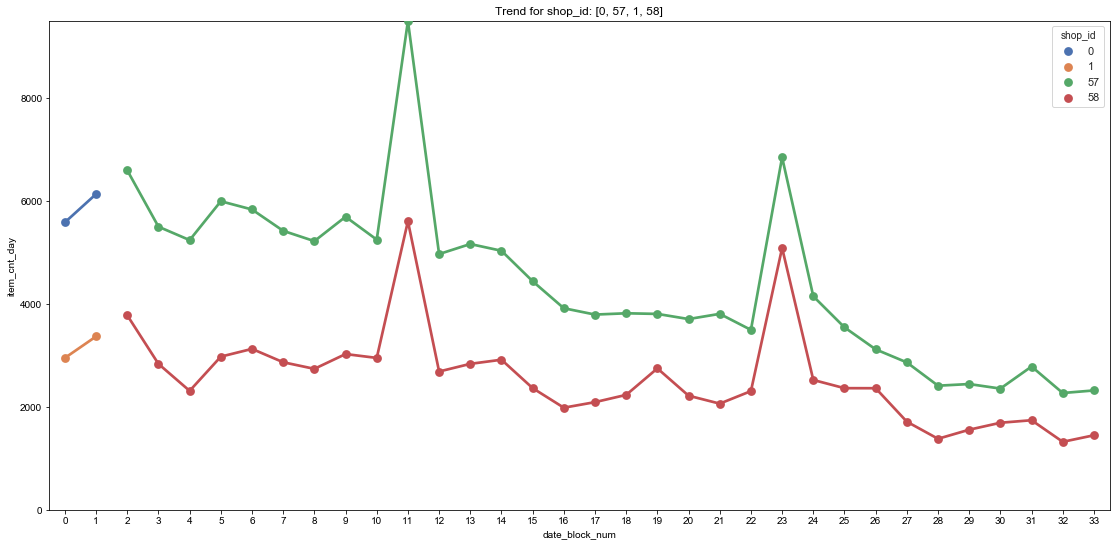

In [12]:
# using the fuzzy logic, I checked on the duplication of the similar shops.
# based on the similarity, certain shops have a 100 token set match. 
# I am performing the sales trend analysis on the similar shops
gb_shop = df_sales.groupby(['shop_id','date_block_num'], as_index=False)['item_cnt_day'].sum()
sales_util.plot_sales_trend([0,57,1,58],'shop_id', gb_shop)

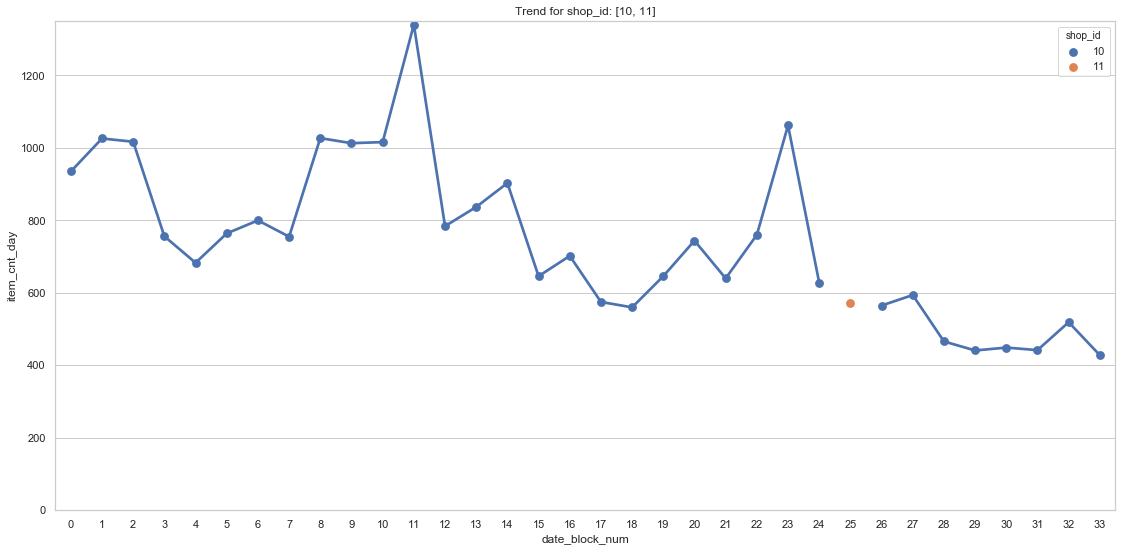

In [13]:
sales_util.plot_sales_trend([10,11],'shop_id', gb_shop)

In [14]:
# based on the above, duplicating as follows
df_sales['shop_id'].replace({0: 57, 1: 58, 11: 10}, inplace=True)

In [17]:
print('There are total of',df_shops.shop_id.nunique(),' shops, let us also examine if there are any outdated shops') 

There are total of 60  shops, let us also examine if there are any outdated shops


### 5. Checking for outdated Shops

We will check the availability of shops by months

In [21]:
avg_not_found = 0
overall_unique_shops = df_shops['shop_id'].unique()

for i in range(0, 34):
    block_unique_shops = df_sales[df_sales['date_block_num']==i]['shop_id'].unique() 
    diff = [shop for shop in overall_unique_shops if shop not in block_unique_shops]
    
    avg_not_found += len(diff)
    print(f'month-{i:02d} - {len(diff):02d} Shops not found  ... ' ,sorted(diff))
    
    
print('')
avg_not_found = avg_not_found/33
print(f'average {avg_not_found:2.2f} shops not available.')

month-00 - 15 Shops not found  ...  [0, 1, 5, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-01 - 14 Shops not found  ...  [0, 1, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-02 - 14 Shops not found  ...  [0, 1, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-03 - 14 Shops not found  ...  [0, 1, 9, 11, 17, 20, 33, 34, 36, 39, 40, 48, 49, 55]
month-04 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 17, 20, 23, 33, 34, 36, 39, 40, 48, 49]
month-05 - 14 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 33, 34, 36, 39, 40, 48, 49]
month-06 - 14 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 33, 34, 36, 39, 40, 48, 49]
month-07 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 49]
month-08 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 49]
month-09 - 14 Shops not found  ...  [0, 1, 8, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 49]
month-10 - 15 Shops not found  ...  [0, 1, 8, 9, 11, 20, 23, 32, 33, 34, 36, 39, 40, 48, 4

**So, the shops that are not available for last 6 months are:**
    - 0, 1, 8, 11, 13, 17, 23, 29, 30, 33, 40, 43, 54
    
**We will clean our dataset by deleting these shops**    

In [23]:
outdated_shops = [0, 1, 8, 11, 13, 17, 23, 29, 30, 33, 40, 43, 54]
df_sales = df_sales[df_sales['shop_id'].isin(outdated_shops)==False]

In [24]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


### 6. Combining all Data-Sets to make one master for our Analysis

In [ ]:
%%time

# Adding the date time attributes (like week day, month number, etc.)
df_sales = sales_util.add_date_attributes(df_sales)

############    ITEMS      ##############
# parsing the item categories (i.e. adding the parent category on top of the item_category)
df_item_categories = sales_util.parse_item_categories(df_item_categories)
# merging the items with item categories
df_items = df_items.merge(df_item_categories, how='inner', on=['item_category_id'])

############    SHOPS      ##############
# Adding the city_id and city_name to the shops
sales_util.parse_shop_names(df_shops)

# merging the sales with the items
df_sales = df_sales.merge(df_items[['item_id','item_category_id','parent_cat_id','parent_cat']].drop_duplicates(), how='inner')

# merging the sales with the shops 
df_sales = df_sales.merge(df_shops[['shop_id','city_id','city_name']].drop_duplicates(), how='inner')

### 7. Checking for duplicated Item Categories

In [ ]:
#based on the fuzzy match between the item categories, probing item categories 
gb_cat = df_sales.groupby(['item_category_id','date_block_num'], as_index=False)['item_cnt_day'].sum()
#comparing item_category_id 8 with 80
sales_util.plot_sales_trend([8,80],'item_category_id', gb_cat) 

In [ ]:
sales_util.plot_sales_trend([27,74],'item_category_id', gb_cat) 

In [ ]:
df_sales['item_category_id'].replace({8: 80, 27: 74}, inplace=True)

### 8. Adding the public holidays to the dataset
* I have gathered all the public holidays from google for the company's country of origin 

In [ ]:
%%time 

# adding the column
df_sales['is_holiday'] = 0

# adding 1 to the specified dates
holidays_list = ['1:1','1:25','2:15','2:27','3:25','4:21','4:26','4:27','6:6','6:8','8:6','8:12','8:27','9:13','9:29','10:1',
                '10:4','10:23','10:24','10:25','10:29','10:30','10:31','11:10','11:19','11:27','12:9','12:17']

for holiday in tqdm_notebook(holidays_list):
    
    # getting the holiday month and day
    m = holiday.split(':')[0] 
    d = holiday.split(':')[1]
    
    m = int(m)
    d = int(d)
    
    # getting the indexes for the holidays    
    dt = df_sales[(df_sales['day']==d) & (df_sales['month']==m)].index
    
    for idx in dt:
        # updating the sales data        
        df_sales.at[idx,'is_holiday'] = 1


In [ ]:
print('total holidays in dataset are ', len(df_sales[df_sales['is_holiday']==1]))

### 9. Down-casting

In [ ]:
%%time
df_sales.info(memory_usage='deep')

In [ ]:
%%time
# down casting
df_sales['date_block_num'] = df_sales['date_block_num'].astype('int8')
df_sales['shop_id'] = df_sales['shop_id'].astype('int8')
df_sales['item_id'] = df_sales['item_id'].astype('int16')
df_sales['item_price'] = df_sales['item_price'].astype('float16')
df_sales['item_cnt_day'] = df_sales['item_cnt_day'].astype('int16')
df_sales['day'] = df_sales['day'].astype('int8')
df_sales['month'] = df_sales['month'].astype('int8')
df_sales['weekdayno'] = df_sales['weekdayno'].astype('int8')
df_sales['year'] = df_sales['year'].astype('int16')
df_sales['item_category_id'] = df_sales['item_category_id'].astype('int8')
df_sales['parent_cat_id'] = df_sales['parent_cat_id'].astype('int8')
df_sales['parent_cat_id'] = df_sales['parent_cat_id'].astype('int8')
df_sales['is_holiday'] = df_sales['is_holiday'].astype('int8')
df_sales['city_id'] = df_sales['city_id'].astype('int8')

# as we have number representations for both of the below, they will be deleted after eda
df_sales['weekday'] = df_sales['weekday'].astype('category')
df_sales['parent_cat'] = df_sales['parent_cat'].astype('category')
df_sales['city_name'] = df_sales['city_name'].astype('category')

In [ ]:
%%time
df_sales.info(memory_usage='deep')

##### we saved huge memory !!

In [ ]:
df_sales.head()

### 10. Saving the master data-set for 

- EDA
- Feature Extraction/Creation

we will start our work from sales combined for EDA

In [ ]:
%%time
del df_item_categories, df_items, df_shops
#df_sales.to_csv('sales_combined.csv', index=False)
df_sales.to_csv(os.path.join(DATA_FOLDER, 'sales_combined.csv'), index=False)
del df_sales
gc.collect()